In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.model_selection import train_test_split

move_bins_for_WCL=np.arange(0,150,5)
eval_bins=np.arange(-20.05,20.15,0.1)
move_bins_for_eval=move_bins_for_WCL


### Get List of Games, Train Test Split

In [ ]:
import anal_games, functions_anal

# Get the list of filenames matching the patterns
filenames_15 = glob.glob("../Cleaned_Analyzed_Games/twic*_15_processed.csv")
filenames_16 = glob.glob("../Cleaned_Analyzed_Games/twic*_16_processed.csv")

# For dupes, use the bigger depth
filenames_to_process=filenames_16
for file in filenames_15:
    if '_'.join(file.split('_')[:3])+'_16_processed.csv' in filenames_to_process:
        continue
    else:
        filenames_to_process.append(file)

outfile='../Cleaned_Analyzed_Games/all_games_cleaned.csv'

# make list of games 
anal_games.process_all_files(outfile=outfile,filenames=filenames_to_process,functions=[functions_anal.MovesTotal,functions_anal.Cleanup,functions_anal.MovesBlack,functions_anal.MovesWhite],skip_if_processed=True,game_wise=True)

df=pd.read_csv(outfile)

dupes=df.duplicated(keep=False,subset=['GameID','File','WhiteName','BlackName','WhiteElo','BlackElo','LineStart','WhiteFideId','BlackFideId','Year','Opening','Variation','Result'])

dupes=dupes.where(dupes) #
dupes.dropna(how='any',inplace=True)
assert len(dupes)==0

df_train,df_test=train_test_split(df,test_size=0.2,random_state=100) # stratification with number of moves or elos doesn't work, as it needs at least two games for each unique value/combination of values. Binning doesn't help

# save training set 
df_train.to_csv('../Cleaned_Analyzed_Games/all_games_cleaned_train.csv',index=False)
df_test.to_csv('../Cleaned_Analyzed_Games/all_games_cleaned_test.csv',index=False)

### Get Winning, Losing and Drawing Chances from Training set

In [ ]:
import winning_chances_util

# make bins for evaluations
eval_bins=np.arange(-20.05,20.15,0.1)

# make bins for moves
move_bins_for_WCL=np.arange(0,150,5)

# Compute winning chance tables from training data
df=pd.read_csv('../Cleaned_Analyzed_Games/all_games_cleaned_train.csv')
winning_chances_util.compute_winning_chance_table(df, intervals=eval_bins,movebins=move_bins_for_WCL,outdir='../winning_chances_tables')

# Same, but only one move bin
winning_chances_util.compute_winning_chance_table(df, intervals=eval_bins,movebins='all',outdir='../winning_chances_tables')


### Calculate Winning Chance Loss for each Game

In [ ]:
import copy
import concurrent.futures
import winning_chances_util
import anal_games

df=pd.read_csv('../Cleaned_Analyzed_Games/all_games_cleaned_train.csv')

process_by_move=True # do we want to have one winning table, or one for each move bracket?

num_workers=15

# for win chances binned by move
move_bins_for_eval=move_bins_for_WCL
wc_tables=winning_chances_util.read_winning_tables(dir='../winning_chances_tables/',movebins=move_bins_for_WCL)
args = []
i_process=0

for i in range(len(move_bins_for_eval)-1):

    
    wc_tables_new=copy.deepcopy(wc_tables)

    # bin moves
    wc_tables_new['mv_min']=move_bins_for_eval[i]
    wc_tables_new['mv_max']=move_bins_for_eval[i+1]

    # only process games with moves in bin
    df_moves=df.where(df['MovesAll']>=move_bins_for_eval[i])
    df_moves=df_moves.where(df['MovesAll']<move_bins_for_eval[i+1])
    df_moves.dropna(how='any',inplace=True)

    if df_moves.shape[0]==0:
        continue

    args.append(('../Cleaned_Analyzed_Games/wcl_train_'+str(move_bins_for_eval[i])+'-'+str(move_bins_for_eval[i+1])+'.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],False,True))
    i_process+=1

wc_tables_new=copy.deepcopy(wc_tables)
wc_tables_new['mv_min']=move_bins_for_eval[-1]
wc_tables_new['mv_max']=100000
args.append(('../Cleaned_Analyzed_Games/wcl_train_'+str(move_bins_for_eval[-1])+'-.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],False,True))
i_process+=1

for i in range(len(move_bins_for_eval)-1):

    
    wc_tables_new=copy.deepcopy(wc_tables)

    # bin moves
    wc_tables_new['mv_min']=move_bins_for_eval[i]
    wc_tables_new['mv_max']=move_bins_for_eval[i+1]

    # only process games with moves in bin
    df_moves=df.where(df['MovesAll']>=move_bins_for_eval[i])
    df_moves=df_moves.where(df['MovesAll']<move_bins_for_eval[i+1])
    df_moves.dropna(how='any',inplace=True)

    if df_moves.shape[0]==0:
        continue

    args.append(('../Cleaned_Analyzed_Games/wcl_test_'+str(move_bins_for_eval[i])+'-'+str(move_bins_for_eval[i+1])+'.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],False,True))
    i_process+=1

wc_tables_new=copy.deepcopy(wc_tables)
wc_tables_new['mv_min']=move_bins_for_eval[-1]
wc_tables_new['mv_max']=100000
args.append(('../Cleaned_Analyzed_Games/wcl_test_'+str(move_bins_for_eval[-1])+'-.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],False,True))
i_process+=1

# run it in parallel
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    tasks = []
    for argument in args:
        tasks.append(executor.submit(anal_games.process_game_list, argument[0],argument[1],argument[2],argument[3],argument[4]))

# for winchances not binned by move

movebins='all'

wc_tables=winning_chances_util.read_winning_tables(dir='../winning_chances_tables/',movebins=movebins)
args = []
i_process=0

for i in range(len(move_bins_for_eval)-1):

    
    wc_tables_new=copy.deepcopy(wc_tables)

    # bin moves
    wc_tables_new['mv_min']=move_bins_for_eval[i]
    wc_tables_new['mv_max']=move_bins_for_eval[i+1]

    # only process games with moves in bin
    df_moves=df.where(df['MovesAll']>=move_bins_for_eval[i])
    df_moves=df_moves.where(df['MovesAll']<move_bins_for_eval[i+1])
    df_moves.dropna(how='any',inplace=True)

    if df_moves.shape[0]==0:
        continue

    args.append(('../Cleaned_Analyzed_Games/wcl_train_all_'+str(move_bins_for_eval[i])+'-'+str(move_bins_for_eval[i+1])+'.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],True,True))
    i_process+=1

wc_tables_new=copy.deepcopy(wc_tables)
wc_tables_new['mv_min']=move_bins_for_eval[-1]
wc_tables_new['mv_max']=100000
args.append(('../Cleaned_Analyzed_Games/wcl_train_all_'+str(move_bins_for_eval[-1]+5)+'-.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],False,True))
i_process+=1

for i in range(len(move_bins_for_eval)-1):

    
    wc_tables_new=copy.deepcopy(wc_tables)

    # bin moves
    wc_tables_new['mv_min']=move_bins_for_eval[i]
    wc_tables_new['mv_max']=move_bins_for_eval[i+1]

    # only process games with moves in bin
    df_moves=df.where(df['MovesAll']>=move_bins_for_eval[i])
    df_moves=df_moves.where(df['MovesAll']<move_bins_for_eval[i+1])
    df_moves.dropna(how='any',inplace=True)

    if df_moves.shape[0]==0:
        continue

    args.append(('../Cleaned_Analyzed_Games/wcl_test_all_'+str(move_bins_for_eval[i])+'-'+str(move_bins_for_eval[i+1])+'.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],True,True))
    i_process+=1

wc_tables_new=copy.deepcopy(wc_tables)
wc_tables_new['mv_min']=move_bins_for_eval[-1]
wc_tables_new['mv_max']=100000
args.append(('../Cleaned_Analyzed_Games/wcl_test_all_'+str(move_bins_for_eval[-1]+5)+'-.csv',df_moves,[(winning_chances_util.WinChanceIncrease,wc_tables_new)],False,True))
i_process+=1

with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    tasks = []
    for argument in args:
        tasks.append(executor.submit(anal_games.process_game_list, argument[0],argument[1],argument[2],argument[3],argument[4]))


### Reshape output tables to have tables by player

In [ ]:
from make_WCL_table import WCL_by_player

# for winchances calculated with binned moves
for i in move_bins_for_eval[-1]:

    WCL_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=False,train=True)
    
WCL_by_player(move_bins_for_eval[-1],None,all=False,train=True)

for i in move_bins_for_eval[-1]:

    WCL_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=False,train=False)
    
WCL_by_player(move_bins_for_eval[-1],None,all=False,train=False)


# for winchances calculated with all moves
for i in move_bins_for_eval[-1]:

    WCL_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=True,train=True)
    
WCL_by_player(move_bins_for_eval[-1],None,all=True,train=True)

for i in move_bins_for_eval[-1]:

    WCL_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=True,train=False)
    
WCL_by_player(move_bins_for_eval[-1],None,all=True,train=False)

### Bin mistakes

In [ ]:
from make_mistakes_table import Mistakes_by_player

# make mistake bins and mistake labels
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]
# start move to count mistakes (counting starts at 0)
move_start=3

# for winchances calculated with binned moves
for i in range(len(move_bins_for_eval[:-1])):

    Mistakes_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=False,train=True,mistake_bins=mistake_bins,move_start=move_start)
    
Mistakes_by_player(move_bins_for_eval[-1],None,all=False,train=True,mistake_bins=mistake_bins,move_start=move_start)

for i in range(len(move_bins_for_eval[:-1])):

    Mistakes_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=False,train=False,mistake_bins=mistake_bins,move_start=move_start)
    
Mistakes_by_player(move_bins_for_eval[-1],None,all=False,train=False,mistake_bins=mistake_bins,move_start=move_start)

# for winchances calculated with all moves
for i in range(len(move_bins_for_eval[:-1])):

    Mistakes_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=True,train=True,mistake_bins=mistake_bins,move_start=move_start)
    
Mistakes_by_player(move_bins_for_eval[-1],None,all=True,train=True,mistake_bins=mistake_bins,move_start=move_start)

for i in range(len(move_bins_for_eval[:-1])):

    Mistakes_by_player(move_bins_for_eval[i],move_bins_for_eval[i+1],all=True,train=False,mistake_bins=mistake_bins,move_start=move_start)
    
Mistakes_by_player(move_bins_for_eval[-1],None,all=True,train=False,mistake_bins=mistake_bins,move_start=move_start)

### Data Analysis

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error


all=False

def get_filename(mv_start,mv_end,train,all):
    filename='../Cleaned_Analyzed_Games/wcl_and_mistakes_'
    if train:
        filename+='train_'
    else:
        filename+='test_'
    if all:
        filename+='all_'
    if mv_end==None:
        filename+=str(mv_start)
    else:
        filename+=str(mv_start)+'-'+str(mv_end)
    filename+='_by_player.csv'
    return filename


for i in [12]: #range(len(move_bins_for_eval[:-1])):

    mv_start=move_bins_for_eval[i]
    mv_end=move_bins_for_eval[i+1]

    filename=get_filename(mv_start,mv_end,train=True,all=all)

    df=pd.read_csv(filename)

    features=[]
    for i in range(1,(mv_start//2)):
        features.append('WCL_'+str(i))
    
    df_white=df.where(df['Player']=='White') # check which training games are in that file
    df_white.dropna(how='any',inplace=True)

    lr_white=LinearRegression()
    
    lr_white.fit(df_white[features],df_white['Elo'].astype(float))

    filename_test=get_filename(mv_start,mv_end,train=False,all=all)

    df_test=pd.read_csv(filename_test)

    df_test_white=df.where(df_test['Player']=='White') # check which training games are in that file
    df_test_white.dropna(how='any',inplace=True)

    print('White Coeffs',lr_white.coef_)
    print('White Intercept',lr_white.intercept_)

    elo_pred_white=lr_white.predict(df_test_white[features])
    residuals_white=df_test_white['Elo']-elo_pred_white
    print('RMS White ', root_mean_squared_error(df_test_white['Elo'], elo_pred_white))

    player_games=  df_test_white[(df_test_white['Elo'] >= 1400) & (df_test_white['Elo'] <= 1500)]

    player_games = player_games.head(20)

    out=lr_white.predict(player_games[features])

    print(out)

    plt.figure()
    plt.scatter(elo_pred_white,residuals_white,label='White',s=.1)
    # plt.scatter(elo_pred_black,residuals_black,label='Black',s=.1)
    plt.legend()
    plt.xlim([1750,2500])
    plt.savefig('Residuals_vs_predicted_'+str(mv_start)+'_'+str(mv_end)+'.png')

    size_move_bins=5

    




5 10
277


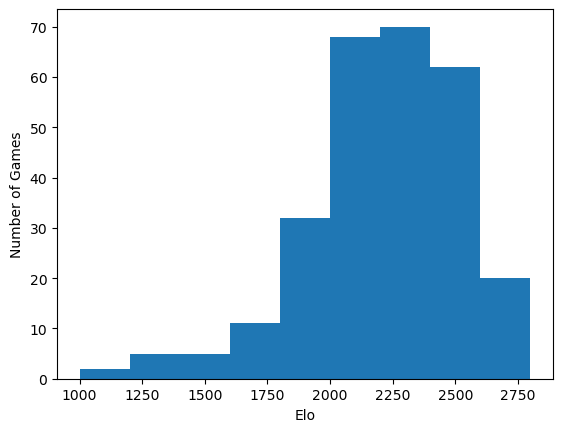

10 15
486


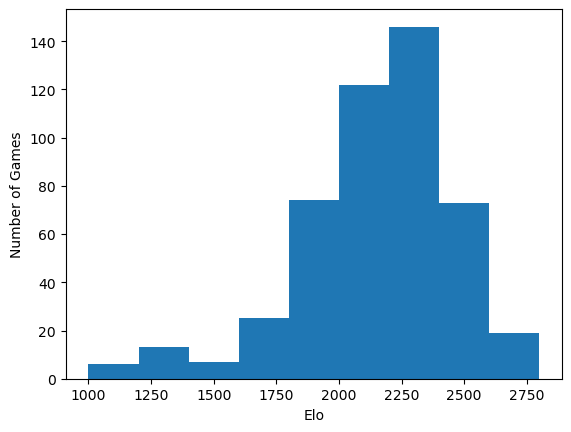

15 20
4578


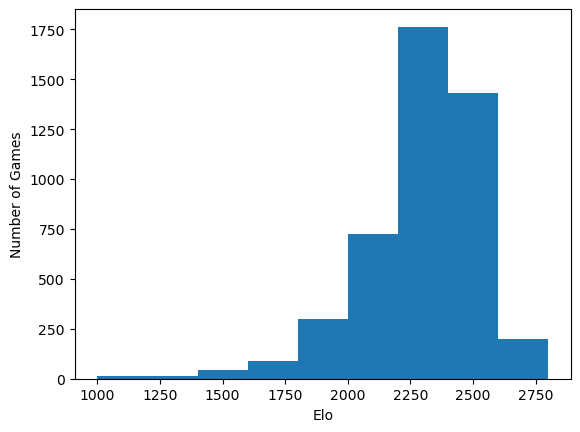

20 25
6564


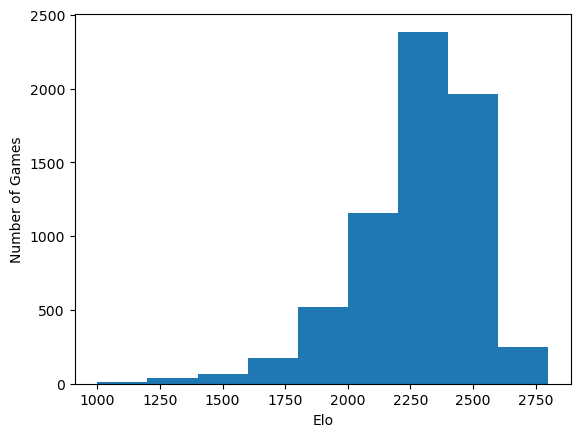

25 30
9079


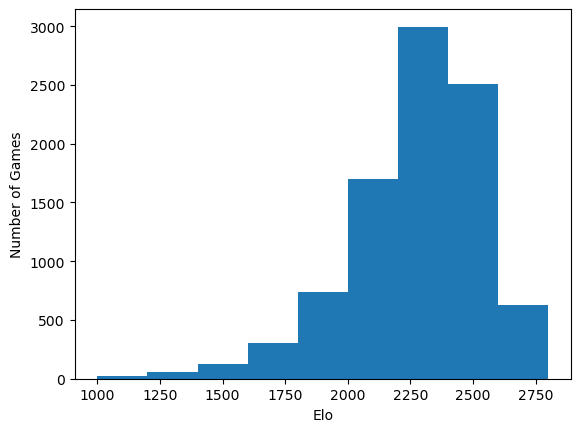

30 35
12046


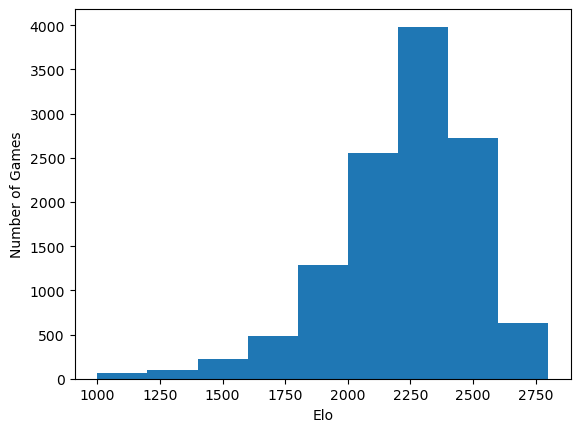

35 40
18805


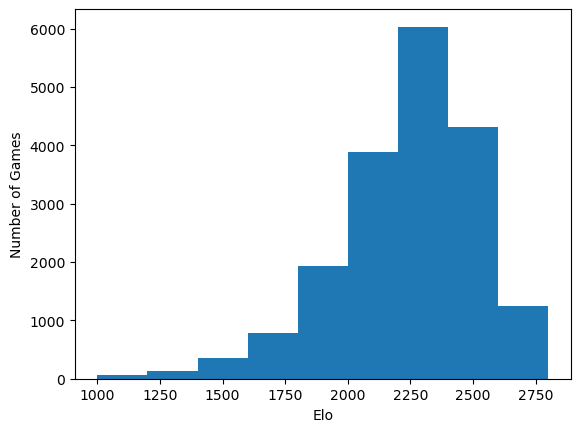

40 45
26259


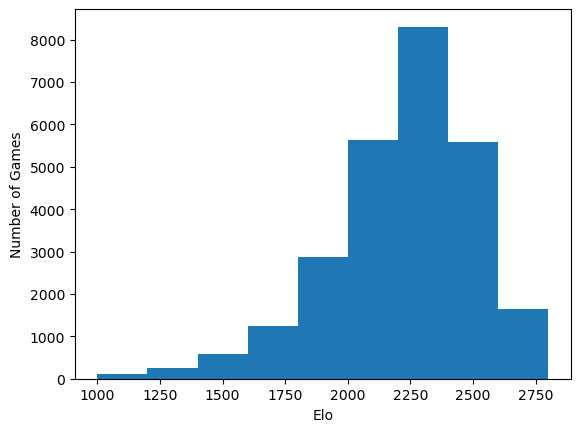

45 50
36777


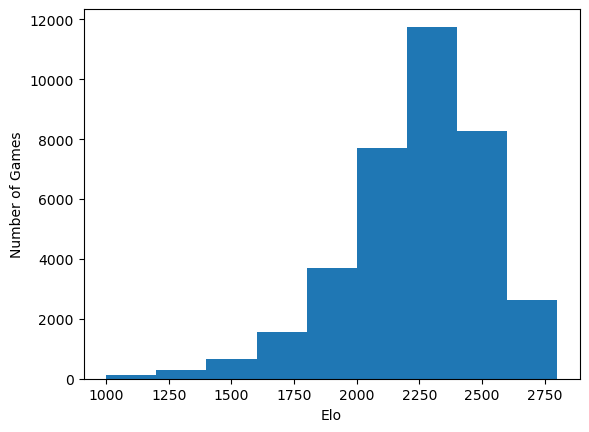

50 55
44655


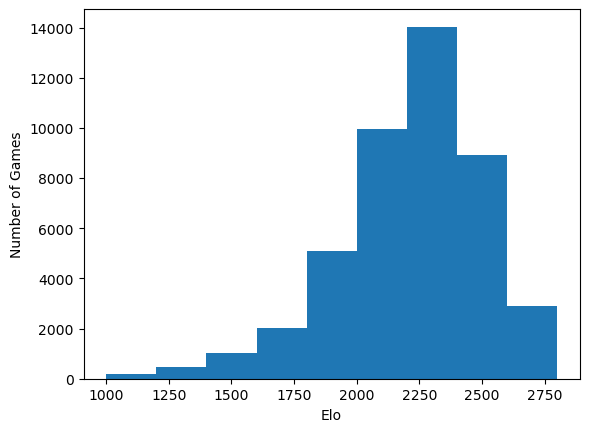

55 60
56308


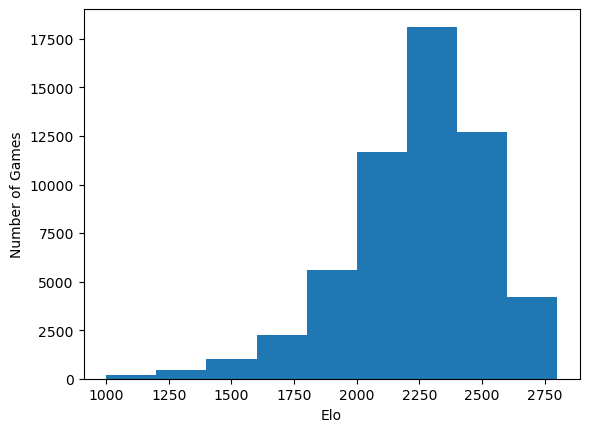

60 65
66325


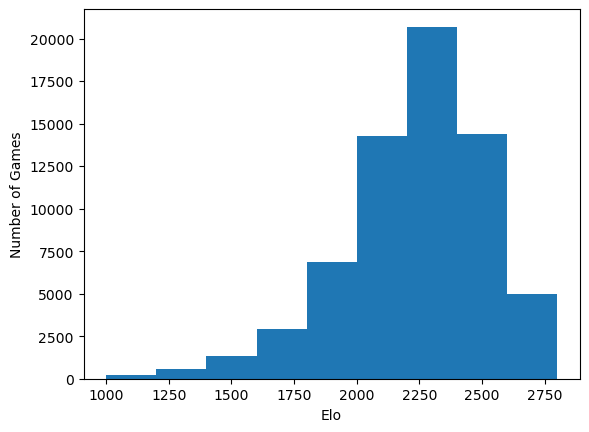

65 70
68293


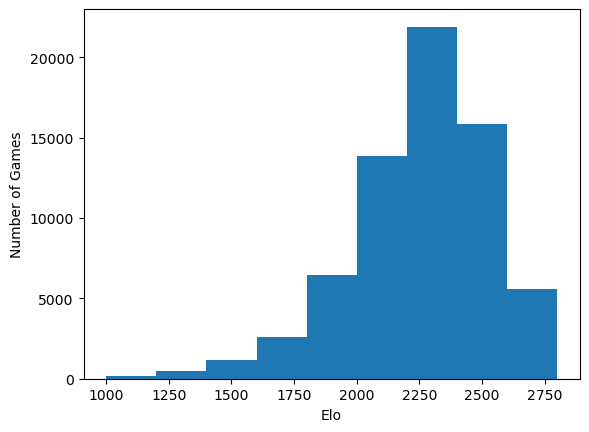

70 75
66835


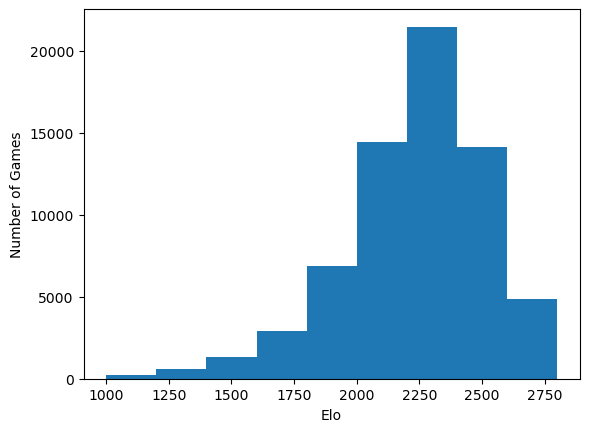

75 80
66732


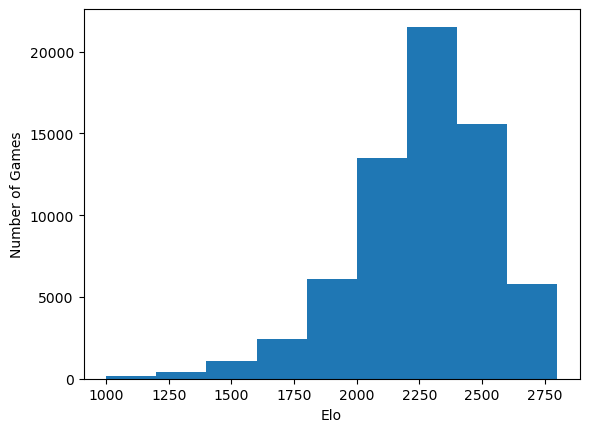

80 85
65698


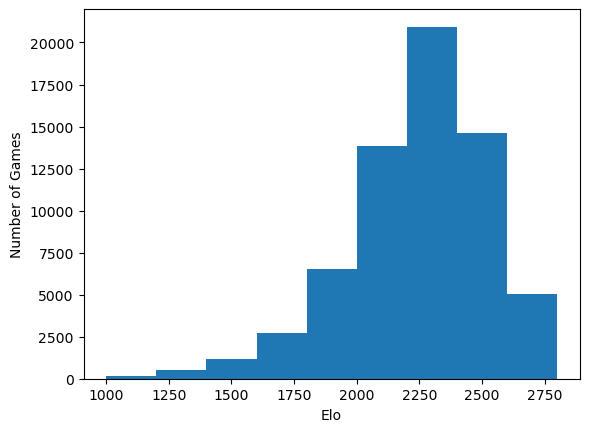

85 90
58125


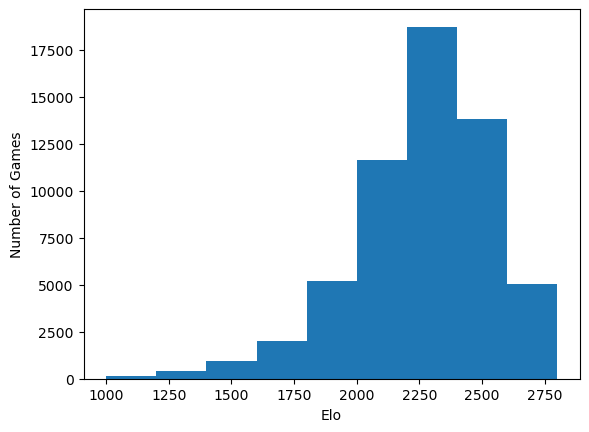

90 95
52117


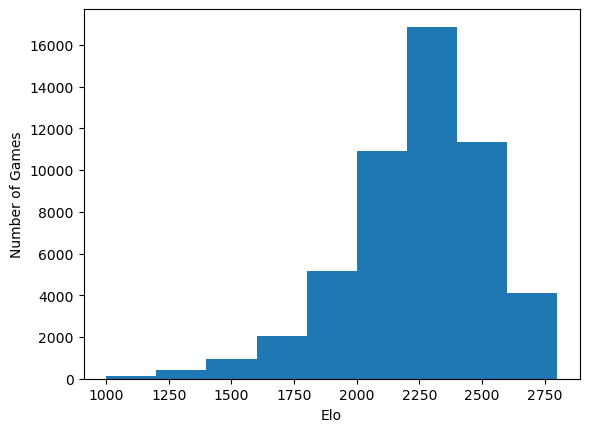

95 100
48193


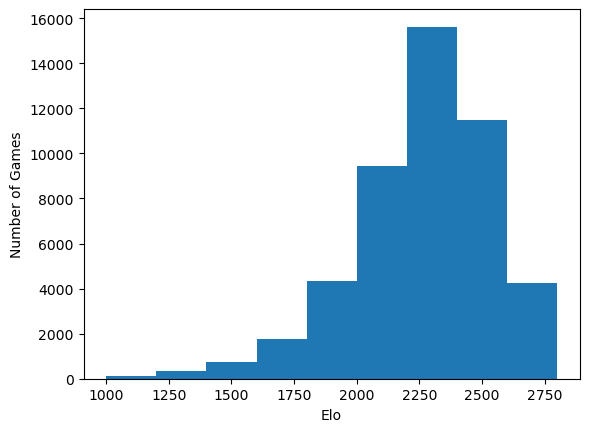

100 105
42751


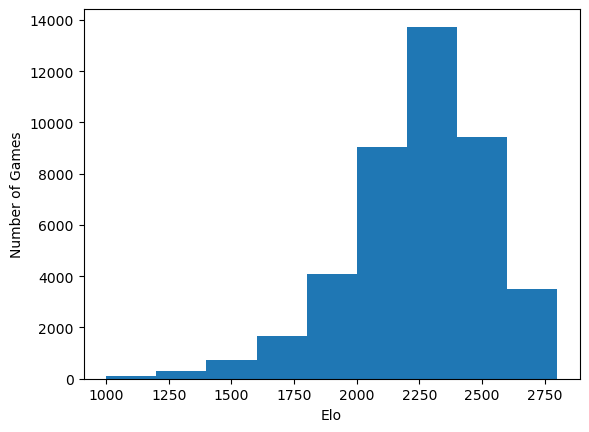

105 110
38937


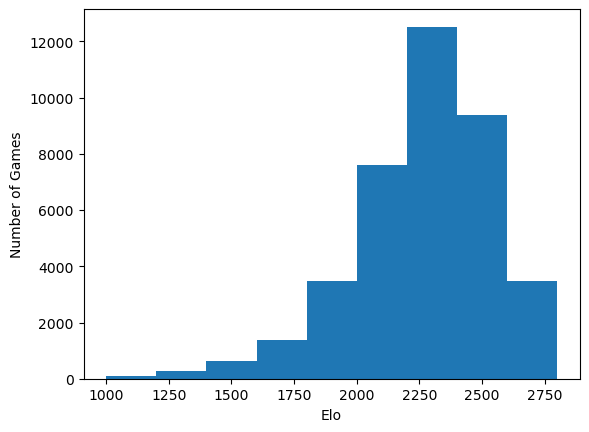

110 115
34629


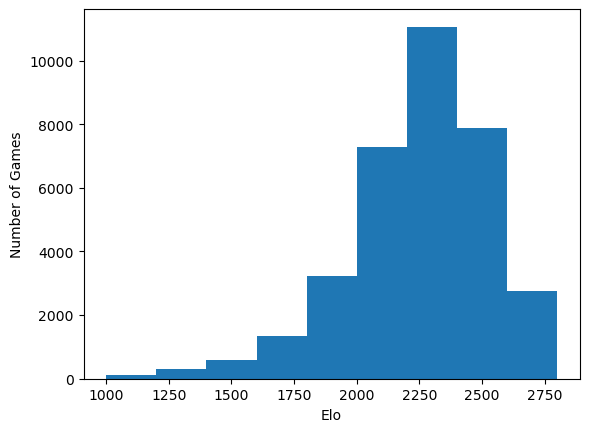

115 120
31906


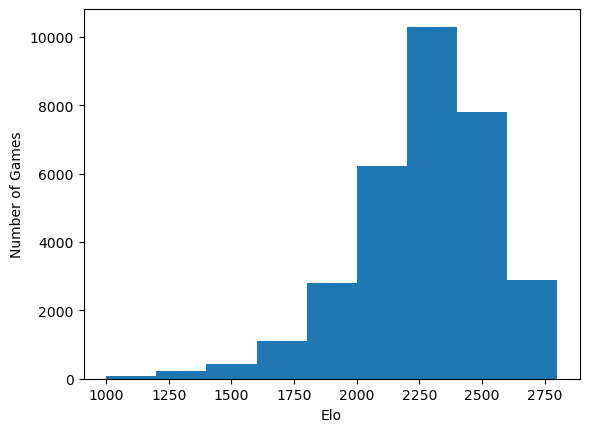

120 125
26566


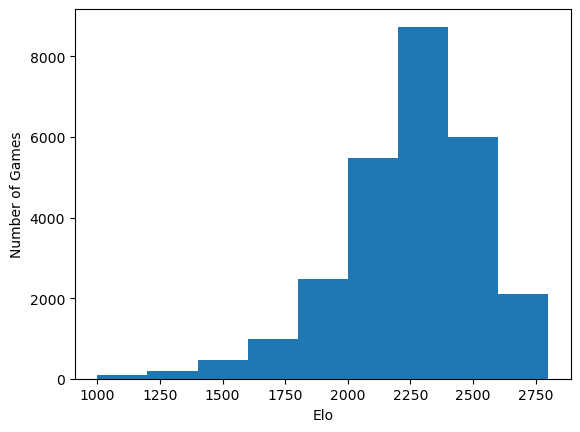

125 130
22266


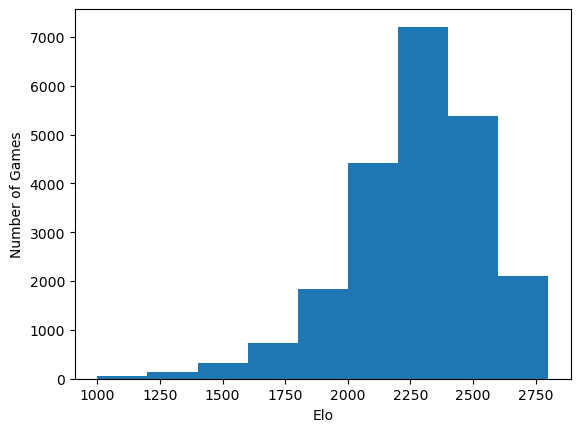

130 135
19210


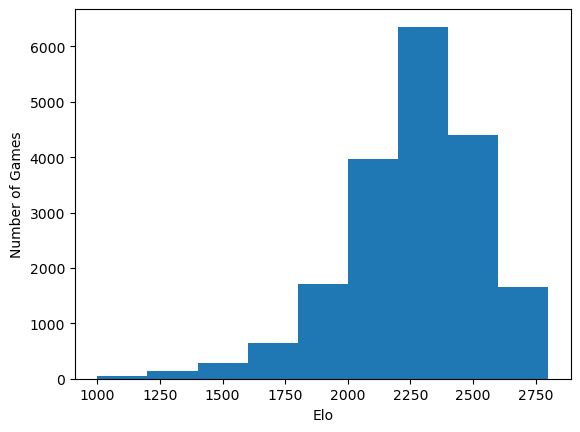

135 140
16677


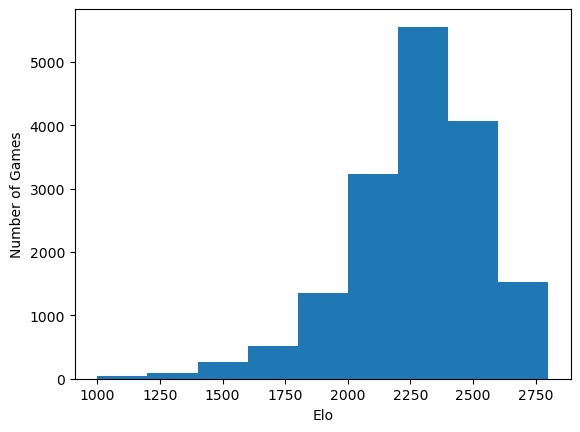

140 145
13751


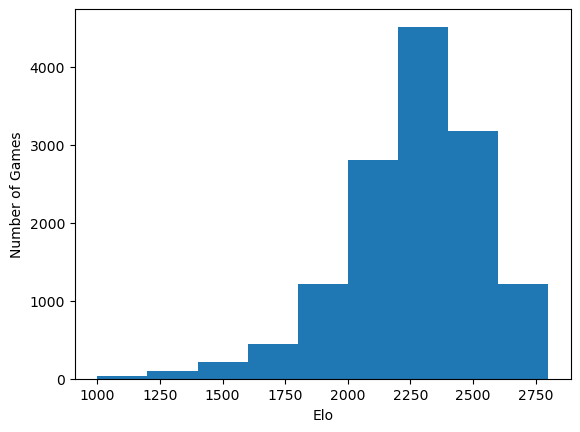

145 None
64771


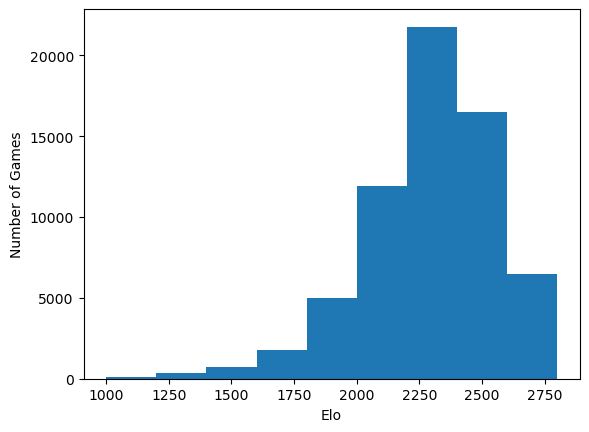

lr
svr
knr
dt
rf
et
ab
gb
xbg


[]

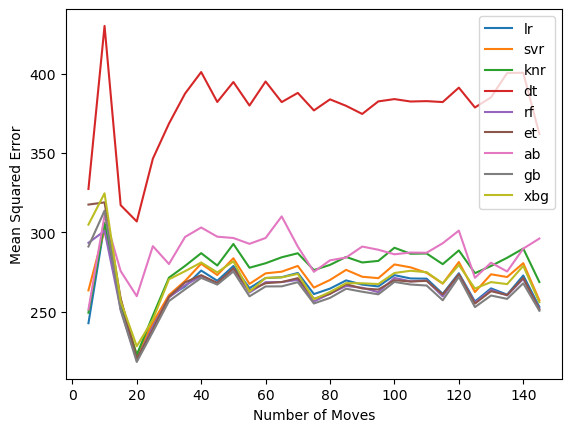

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pandas as pd
from sklearn.metrics import root_mean_squared_error

move_bins_for_WCL=np.arange(0,150,5)
eval_bins=np.arange(-20.05,20.15,0.1)
move_bins_for_eval=move_bins_for_WCL

models = {
    'lr': LinearRegression(),
    'svr': SVR(),
    'knr': KNeighborsRegressor(n_neighbors=10),
    'dt' : DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'et': ExtraTreesRegressor(),
    'ab': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'xbg': XGBRegressor()
}

all=False

def get_filename(mv_start,mv_end,train,all):
    filename='../Cleaned_Analyzed_Games/wcl_and_mistakes_'
    if train:
        filename+='train_'
    else:
        filename+='test_'
    if all:
        filename+='all_'
    if mv_end==None:
        filename+=str(mv_start)+'-'
    else:
        filename+=str(mv_start)+'-'+str(mv_end)
    filename+='_by_player.csv'
    return filename

mses = {}
for model in models:
    mses[model]=[]

# print(mses.keys())

for i in range(1,len(move_bins_for_eval[:])):

    mv_start=move_bins_for_eval[i]
    if i<len(move_bins_for_eval[:])-1:
        mv_end=move_bins_for_eval[i+1]
    else:
        mv_end=None

    print(mv_start,mv_end)

    filename=get_filename(mv_start,mv_end,train=True,all=all)
    # print(filename)

    df=pd.read_csv(filename)

    features=[]
    for j in range(1,(mv_start//2)):
        features.append('WCL_'+str(j))
    target='Elo'
    # print(features)
    
    df_white=df.where(df['Player']=='White') # check which training games are in that file
    df_white.dropna(how='all',inplace=True)

    ## make a validation set
    print(len(df_white))
    df_tt, df_val = train_test_split(df_white, 
                                        shuffle=True,
                                        random_state=216,
                                        test_size=.1)

    # mses[mv_start] = {}
    for name, model in models.items():
        # print('testing & validation')
        model.fit(df_tt[features],df_tt[target])
        mses[name].append(root_mean_squared_error(df_val[target], model.predict(df_val[features])))

        # player_games=  df_val[(df_val[target] >= 1400) & (df_val[target] <= 1500)]

        # player_games = player_games.head(20)

        # out=model.predict(player_games[features])

        # print(name)

        # print(out)
    
    # filename_test=get_filename(mv_start,mv_end,train=False,all=all)
    # print(filename_test)

    # df_test=pd.read_csv(filename_test)

    # df_test_white=df_test.where(df_test['Player']=='White') # check which training games are in that file
    # df_test_white.dropna(how='any',inplace=True)

    # # common_rows = pd.merge(df_white, df_test_white, how='inner', on=['File','Name','GameID'])
    # dupes_train=df_white.duplicated(keep=False)
    # print(dupes_train.index[dupes_train == True].tolist())
    # dupes_train=dupes_train.where(dupes_train) #
    # dupes_train.dropna(how='any',inplace=True)
    # assert len(dupes_train)==0

    # dupes_test=df_test_white.duplicated(keep=False)
    # print(dupes_test.index[dupes_test == True].tolist())
    # dupes_test=dupes_test.where(dupes_test) #
    # dupes_test.dropna(how='any',inplace=True)
    # assert len(dupes_test)==0

    # df_check_dupes=pd.concat([df_white,df_test_white])

    # dupes=df_check_dupes.duplicated(keep=False)
    # print(dupes.index[dupes == True].tolist())
    # dupes=dupes.where(dupes) #
    # dupes.dropna(how='any',inplace=True)
    # print(len(dupes))
    # print(dupes.iloc[0])
    # print(df_white.iloc[dupes.index[dupes == True].tolist()[0]].to_dict())
    # dupe_line_1=df_white.iloc[dupes.index[dupes == True].tolist()[0]].to_dict()
    # print(df_test_white.loc[(df['Opening'] == dupe_line_1['Opening']) & (df['Name'] == dupe_line_1['Name'])].to_dict())
    # assert len(dupes)==0
        
    # print(common_rows.head())
    # print(len(common_rows))

    # mses2 = {}
    # for name, model in models.items():
    #     print('train & test')
    #     model.fit(df_white[features],df_white[target])
    #     mses2[name] = mean_squared_error(df_test_white[target], model.predict(df_test_white[features]))

    #     player_games=  df_test_white[(df_test_white[target] >= 1400) & (df_test_white[target] <= 1500)]

    #     player_games = player_games.head(20)

    #     out=model.predict(player_games[features])

    #     print(name)

    #     print(out)
    
    plt.figure()
    plt.hist(df_white['Elo'],bins=np.arange(1000,3000,200))
    plt.xlabel('Elo')
    plt.ylabel('Number of Games')
    plt.show()

    # print(mses.keys())


# print(mses.keys())

plt.figure()
for model in mses:
    print(model)
    plt.plot(move_bins_for_eval[1:],mses[model],label=model)
plt.xlabel('Number of Moves')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.plot()
# print(mses[mv_start])
# print(mses2)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pandas as pd
from sklearn.metrics import root_mean_squared_error

move_bins_for_WCL=np.arange(0,150,5)
eval_bins=np.arange(-20.05,20.15,0.1)
move_bins_for_eval=move_bins_for_WCL

models = {
    'lr': LinearRegression(),
    'svr': SVR(),
    'knr': KNeighborsRegressor(n_neighbors=10),
    'dt' : DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'et': ExtraTreesRegressor(),
    'ab': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'xbg': XGBRegressor()
}

all=False

def get_filename(mv_start,mv_end,train,all):
    filename='../Cleaned_Analyzed_Games/wcl_and_mistakes_'
    if train:
        filename+='train_'
    else:
        filename+='test_'
    if all:
        filename+='all_'
    if mv_end==None:
        filename+=str(mv_start)+'-'
    else:
        filename+=str(mv_start)+'-'+str(mv_end)
    filename+='_by_player.csv'
    return filename

mses = {}
for model in models:
    mses[model]=[]

# print(mses.keys())

mv_start=move_bins_for_eval[0]
mv_end=move_bins_for_eval[1]
filename=get_filename(mv_start,mv_end,train=True,all=all)
df=pd.read_csv(filename)

for i in range(1,len(move_bins_for_eval[:])):

    mv_start=move_bins_for_eval[i]
    if i<len(move_bins_for_eval[:])-1:
        mv_end=move_bins_for_eval[i+1]
    else:
        mv_end=None

    print(mv_start,mv_end)

    filename=get_filename(mv_start,mv_end,train=True,all=all)
    # print(filename)

    df_new=pd.read_csv(filename)
    df=pd.concat([df,df_new],axis=1)

# make mistake bins and mistake labels
mistake_bins = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 100]
# start move to count mistakes (counting starts at 0)
move_start=3

# make mistake tables
features=[]
for i in range(len(mistake_bins[:-1])):
    features.append(pd.Interval(mistake_bins[i],mistake_bins[i+1]))

target='Elo'
# print(features)

df_white=df.where(df['Player']=='White') # check which training games are in that file
df_white.dropna(how='all',inplace=True)

## make a validation set
print(len(df_white))
df_tt, df_val = train_test_split(df_white, 
                                    shuffle=True,
                                    random_state=216,
                                    test_size=.1)

# mses[mv_start] = {}
for name, model in models.items():
    # print('testing & validation')
    model.fit(df_tt[features],df_tt[target])
    mses[name].append(root_mean_squared_error(df_val[target], model.predict(df_val[features])))

print(mses)

plt.figure()
for model in mses:
    print(model)
    plt.plot(move_bins_for_eval[1:],mses[model],label=model)
plt.xlabel('Number of Moves')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.plot()
# print(mses[mv_start])
# print(mses2)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pandas as pd

from sklearn.metrics import mean_squared_error

models = {
    'lr': LinearRegression(),
    'svr': SVR(),
    'knr': KNeighborsRegressor(n_neighbors=10),
    'dt' : DecisionTreeRegressor(),
    'rf': RandomForestRegressor(),
    'et': ExtraTreesRegressor(),
    'ab': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'xbg': XGBRegressor()
}

all=False

def get_filename(mv_start,mv_end,train,all):
    filename='../Cleaned_Analyzed_Games/wcl_and_mistakes_'
    if train:
        filename+='train_'
    else:
        filename+='test_'
    if all:
        filename+='all_'
    if mv_end==None:
        filename+=str(mv_start)
    else:
        filename+=str(mv_start)+'-'+str(mv_end)
    filename+='_by_player.csv'
    return filename


for i in [20]: #range(len(move_bins_for_eval[:-1])):

    mv_start=move_bins_for_eval[i]
    mv_end=move_bins_for_eval[i+1]

    filename=get_filename(mv_start,mv_end,train=True,all=all)
    print(filename)

    df=pd.read_csv(filename)

    features=[]
    for j in range(1,(mv_start//10)):
        features.append('Mean_'+str(j))
        df['Mean_'+str(j)]=df[['WCL_'+str(i) for i in range((j-1)*5, j*5)]].mean(axis=1)

    # for i in range(1,(mv_start//2)):
    #     features.append('WCL_'+str(i))
    target='Elo'
    
    df_white=df.where(df['Player']=='White') # check which training games are in that file
    df_white.dropna(how='any',inplace=True)

    plt.figure()
    plt.hist(df_white['Elo'])
    plt.show()

    ## make a validation set
    df_tt, df_val = train_test_split(df_white, 
                                        shuffle=True,
                                        random_state=216,
                                        test_size=.1)

    mses = {}
    for name, model in models.items():
        print('testing & validation')
        model.fit(df_tt[features],df_tt[target])
        mses[name] = mean_squared_error(df_val[target], model.predict(df_val[features]))

        player_games=  df_val[(df_val[target] >= 1400) & (df_val[target] <= 1500)]

        player_games = player_games.head(20)

        out=model.predict(player_games[features])

        print(name)

        print(out)
    
    # filename_test=get_filename(mv_start,mv_end,train=False,all=all)
    # print(filename_test)

    # df_test=pd.read_csv(filename_test)

    # for j in range(1,(mv_start//10)):
    #     df_test['Mean_'+str(j)]=df_test[['WCL_'+str(i) for i in range((j-1)*5, j*5)]].mean(axis=1)

    # df_test_white=df_test.where(df_test['Player']=='White') # check which training games are in that file
    # df_test_white.dropna(how='any',inplace=True)

    

    # # common_rows = pd.merge(df_white, df_test_white, how='inner', on=['File','Name','GameID'])
    # dupes_train=df_white.duplicated(keep=False)
    # print(dupes_train.index[dupes_train == True].tolist())
    # dupes_train=dupes_train.where(dupes_train) #
    # dupes_train.dropna(how='any',inplace=True)
    # assert len(dupes_train)==0

    # dupes_test=df_test_white.duplicated(keep=False)
    # print(dupes_test.index[dupes_test == True].tolist())
    # dupes_test=dupes_test.where(dupes_test) #
    # dupes_test.dropna(how='any',inplace=True)
    # assert len(dupes_test)==0

    # df_check_dupes=pd.concat([df_white,df_test_white])

    # dupes=df_check_dupes.duplicated(keep=False)
    # print(dupes.index[dupes == True].tolist())
    # dupes=dupes.where(dupes) #
    # dupes.dropna(how='any',inplace=True)
    # print(len(dupes))
    # print(dupes.iloc[0])
    # print(df_white.iloc[dupes.index[dupes == True].tolist()[0]].to_dict())
    # dupe_line_1=df_white.iloc[dupes.index[dupes == True].tolist()[0]].to_dict()
    # print(df_test_white.loc[(df['Opening'] == dupe_line_1['Opening']) & (df['Name'] == dupe_line_1['Name'])].to_dict())
    # assert len(dupes)==0
        
    # print(common_rows.head())
    # print(len(common_rows))

    # mses2 = {}
    # for name, model in models.items():
    #     print('train & test')
    #     model.fit(df_white[features],df_white[target])
    #     mses2[name] = mean_squared_error(df_test_white[target], model.predict(df_test_white[features]))

    #     player_games=  df_test_white[(df_test_white[target] >= 1400) & (df_test_white[target] <= 1500)]

    #     player_games = player_games.head(20)

    #     out=model.predict(player_games[features])

    #     print(name)

    #     print(out)

print(mses)
# print(mses2)